In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import glob
sns.set_style('white')
sns.set_context('talk', font_scale=2)

In [3]:
config = tf.ConfigProto(
    device_count = {'GPU': 0}
)
config.gpu_options.allocator_type = 'BFC'
#config

IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
IMAGE_CHANNELS = 3

class VAE(object):
    def __init__(self, input_dim, 
                 learning_rate=0.001, 
                 n_latent=8, batch_size=50):
        self.learning_rate = learning_rate
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.input_dim = input_dim
        
        self._build_network()
        self._create_loss_optimizer()

        
        init = tf.global_variables_initializer()        
        #init = tf.initialize_all_variables()
        # Launch the session
        self.session = tf.InteractiveSession(config=config)
        self.session.run(init)
        self.saver = tf.train.Saver(tf.global_variables())
        
    
    def _build_network(self):        
        self.x = tf.placeholder(tf.float32, [None, self.input_dim])
        dense1 = tf.layers.dense(activation=tf.nn.elu, inputs=self.x, units=512)
        dense2 = tf.layers.dense(activation=tf.nn.elu, inputs=dense1, units=512)
        dense3 = tf.layers.dense(activation=tf.nn.elu, inputs=dense2, units=512)
        dense4 = tf.layers.dense(activation=None, inputs=dense3, units=self.n_latent * 2)
        self.mu = dense4[:, :self.n_latent]
        self.sigma = tf.nn.softplus(dense4[:, self.n_latent:])
        eps = tf.random_normal(shape=tf.shape(self.sigma),
                               mean=0, stddev=1, dtype=tf.float32)
        self.z = self.mu + self.sigma * eps
        
        ddense1 = tf.layers.dense(activation=tf.nn.elu, inputs=self.z, units=512)
        ddense2 = tf.layers.dense(activation=tf.nn.elu, inputs=ddense1, units=512)
        ddense3 = tf.layers.dense(activation=tf.nn.elu, inputs=ddense2, units=512)

        self.reconstructed = tf.layers.dense(activation=tf.nn.sigmoid, inputs=ddense3,
                                            units=self.input_dim)
    
    def _create_loss_optimizer(self):
        #self.reconstruction_loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=self.x,
        #                                                                  logits=self.reconstructed))
        epsilon = 1e-10
        reconstruction_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.reconstructed) + (1-self.x) * tf.log(epsilon+1-self.reconstructed), 
            axis=1
        )
        
        self.reconstruction_loss = tf.reduce_mean(reconstruction_loss) / self.batch_size
        
        latent_loss = -0.5 * tf.reduce_sum(1 + tf.log(epsilon+self.sigma) - tf.square(self.mu) - tf.square(self.sigma),
                                           axis=1)
        latent_loss = tf.reduce_mean(latent_loss) / self.batch_size
        self.latent_loss = latent_loss
        self.cost = tf.reduce_mean(self.reconstruction_loss + self.latent_loss)
        # ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)         
    
    
    def fit_minibatch(self, batch):
        _, cost, reconstruction_loss, latent_loss = self.session.run([self.optimizer,
                                                                            self.cost,
                                                                            self.reconstruction_loss,
                                                                            self.latent_loss], 
                                                                           feed_dict = {self.x: batch})
        return  cost, reconstruction_loss, latent_loss
    
    def reconstruct(self, x):
        return self.session.run([self.reconstructed], feed_dict={self.x: x})
    
    def decoder(self, z):
        return self.session.run([self.reconstructed], feed_dict={self.z: z})
    
    def encoder(self, x):
        return self.session.run([self.z], feed_dict={self.x: x})

    def save_model(self, checkpoint_path, epoch):
        self.saver.save(self.session, checkpoint_path, global_step = epoch)

    def load_model(self, checkpoint_dir):
        #new_saver = tf.train.import_meta_graph(checkpoint_path)
        #new_saver.restore(sess, tf.train.latest_checkpoint('./'))
        
        ckpt = tf.train.get_checkpoint_state(checkpoint_dir=checkpoint_dir, latest_filename='checkpoint')
        print('loading model: {}'.format(ckpt.model_checkpoint_path))
        self.saver.restore(self.session, ckpt.model_checkpoint_path)
    

In [4]:
input_dim = IMAGE_WIDTH * IMAGE_HEIGHT * IMAGE_CHANNELS 
model = VAE(input_dim, n_latent=10)

In [5]:
model.load_model('/Z/personal-folders/interns/saket/vae_checkpoint_histoapath_2000/')


loading model: /Z/personal-folders/interns/saket/vae_checkpoint_histoapath_2000/model.ckpt-995-995
INFO:tensorflow:Restoring parameters from /Z/personal-folders/interns/saket/vae_checkpoint_histoapath_2000/model.ckpt-995-995


In [9]:
normal_patches_dir = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16_patches/normal_patches_test/level_0/'
tumor_patches_dir = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16_patches/tumor_patches_test/level_0/'

np.random.seed(42)
master_matrix = []
label_matrix = []
y = []
list_of_tumor_files = list(glob.glob('{}*.png'.format(tumor_patches_dir)))
list_of_normal_files = list(glob.glob('{}*.png'.format(normal_patches_dir)))

In [10]:
from skimage.io import imread
data = imread(list_of_tumor_files[0])

In [11]:
standardized = (data / 255.0).reshape(-1, 256 * 256 * 3)

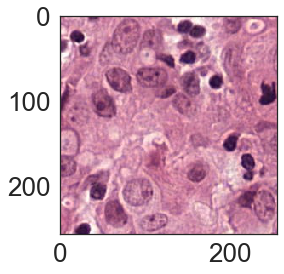

In [13]:
plt.imshow(standardized.reshape((256, 256, 3)))

In [14]:
reconstructed = model.reconstruct(standardized)

In [17]:
reconstructed[0].shape

(1, 196608)

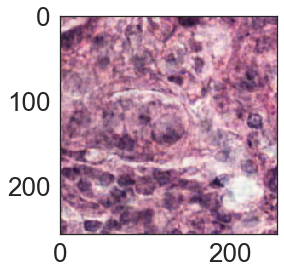

In [18]:
plt.imshow(reconstructed[0].reshape(256, 256, 3))